In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

## (a) Load the AReM Dataset

In [6]:
# Function used for load the AReM dataset
def load_arem(root_dir='./AReM'):
    data = []
    labels = []
    activities = sorted(os.listdir(root_dir))

    for act in activities:
        act_dir = os.path.join(root_dir, act)
        if not os.path.isdir(act_dir):
            continue
        for fname in os.listdir(act_dir):
            if fname.endswith(".csv"):
                fpath = os.path.join(act_dir, fname)
                try:
                    df = pd.read_csv(fpath, skiprows=4)  # Skip first 4 rows of description.
                    df = df.drop(columns=df.columns[0])  # Delete the first column (timestamp).
                    if df.shape != (480, 6):  # Check the shape of read dataset.
                        continue
                    data.append(df)
                    labels.append(act)
                except Exception as e:
                    print(f"Error reading {fpath}: {e}")
    return data, labels

In [10]:
data, labels = load_arem()

## (b) Split the Dataset into Training and Test Sets

In [11]:
# Function used for split the dataset
def split_data(data, labels):
    label_to_idx = defaultdict(list)
    for idx, label in enumerate(labels):
        label_to_idx[label].append(idx)

    train_idx = []
    test_idx = []

    for label, idx in label_to_idx.items():
        if label in ["bending1", "bending2"]:
            test_idx.extend(idx[:2])
            train_idx.extend(idx[2:])
        else:
            test_idx.extend(idx[:3])
            train_idx.extend(idx[3:])
    return train_idx, test_idx

In [12]:
train_idx, test_idx = split_data(data, labels)

## (c) Feature Extraction

### (i) Time-domain features are usually used in time series classification:

#### Minimum, Maximum, Mean, Median, Standard Deviation, Variance, Percentiles.

### (ii) Extracting minimum, maximum, mean, median, standard deviation, first quartile and third quartile.

In [46]:
# Function used for extract statistics.
def extract_features(df):
    stats = []
    for col in df.columns:
        series = df[col]
        stats.extend([
            series.min(),
            series.max(),
            series.mean(),
            series.median(),
            series.std(),
            np.percentile(series, 25),
            np.percentile(series, 75)
        ])
    return stats

# Function used for build dataframe of data with features.
def build_feature_df(data, labels):
    features = []
    for df in data:
        feats = extract_features(df)
        features.append(feats)

    columns = []
    for i in range(6):  #  For all the 6 time series in each instance
        for stat in ["min", "max", "mean", "median", "std", "1st_quart", "3rd_quart"]:
            columns.append(f"series{i+1}_{stat}")

    return pd.DataFrame(features, columns=columns), labels


In [47]:
full_df, all_labels = build_feature_df(data, labels)

In [48]:
# Check the dataset
print(full_df)

    series1_min  series1_max  series1_mean  series1_median  series1_std  \
0         37.25        45.00     40.624792          40.500     1.476967   
1         38.00        45.67     42.812812          42.500     1.435550   
2         35.00        47.40     43.954500          44.330     1.558835   
3         33.00        47.75     42.179812          43.500     3.670666   
4         33.00        45.75     41.678063          41.750     2.243490   
..          ...          ...           ...             ...          ...   
82        20.75        46.25     34.763333          35.290     4.742208   
83        21.50        51.00     34.935812          35.500     4.645944   
84        18.33        47.67     34.333042          34.750     4.948770   
85        18.33        45.75     34.599875          35.125     4.731790   
86        15.50        43.67     34.225875          34.750     4.441798   

    series1_1st_quart  series1_3rd_quart  series2_min  series2_max  \
0               39.25        

### (iii) Estimating the standard deviation and build 90% bootstrap confidence interval.

In [49]:
# Function used for give the 90% bootstrap CI.
def bs_std_ci(dataframe, n_bootstrap=1000, confidence=0.90):
    ci_low, ci_high = (1 - confidence) / 2, 1 - (1 - confidence) / 2
    results = []

    for col in dataframe.columns:
        vals = dataframe[col].dropna().astype(float).values
        bootstrapped_stds = []

        for _ in range(n_bootstrap):
            sample = np.random.choice(vals, size=len(vals), replace=True)
            bootstrapped_stds.append(np.std(sample, ddof=1))

        lower = np.percentile(bootstrapped_stds, 100 * ci_low)
        upper = np.percentile(bootstrapped_stds, 100 * ci_high)
        true_std = np.std(vals, ddof=1)

        results.append({
            'feature': col,
            'std': true_std,
            'ci_lower': lower,
            'ci_upper': upper
        })
    return pd.DataFrame(results)

In [50]:
ci_df = bs_std_ci(full_df.loc[:87])
print(ci_df)
print(ci_df.shape)

              feature       std  ci_lower   ci_upper
0         series1_min  9.576883  8.315384  10.785072
1         series1_max  4.231890  3.187975   5.211187
2        series1_mean  5.291157  4.629232   5.856958
3      series1_median  5.404425  4.774848   5.983139
4         series1_std  1.766622  1.552399   1.949251
5   series1_1st_quart  6.140677  5.579516   6.621166
6   series1_3rd_quart  5.054959  4.165291   5.777684
7         series2_min  0.000000  0.000000   0.000000
8         series2_max  5.057236  4.649908   5.393241
9        series2_mean  1.582306  1.396972   1.704166
10     series2_median  1.418644  1.249242   1.548628
11        series2_std  0.887453  0.806915   0.945554
12  series2_1st_quart  0.950444  0.837124   1.039400
13  series2_3rd_quart  2.137639  1.913495   2.309270
14        series3_min  2.952073  2.761171   3.100081
15        series3_max  4.848106  4.181028   5.443681
16       series3_mean  3.987966  3.387677   4.503946
17     series3_median  4.016916  3.365676   4.

### (iv) Select the three most important time-domain features.

In [51]:
# Seperate sensor{num}_stat into two columns.
ci_df[['series', 'stat']] = ci_df['feature'].str.extract(r'(series\d+)_(.+)')

# Using stats divide the data, calculate the average of std.
stat_grouped = ci_df.groupby('stat')['std'].mean().sort_values(ascending=False)

# Get top3 features.
top3_stats = stat_grouped.head(3)

print("Top 3 time-domain features (by avg std across series):")
print(top3_stats)

Top 3 time-domain features (by avg std across series):
stat
max          4.113454
3rd_quart    3.340167
1st_quart    3.174561
Name: std, dtype: float64


#### We selected Maximum, 3rd Quartile and 1st Quartile as the three most important features because they have highest standard deviation. Larger standard deviation indicates greater discrimenative power, which is beneficial for classification.

### (v) Training and testing by selected features and instances.

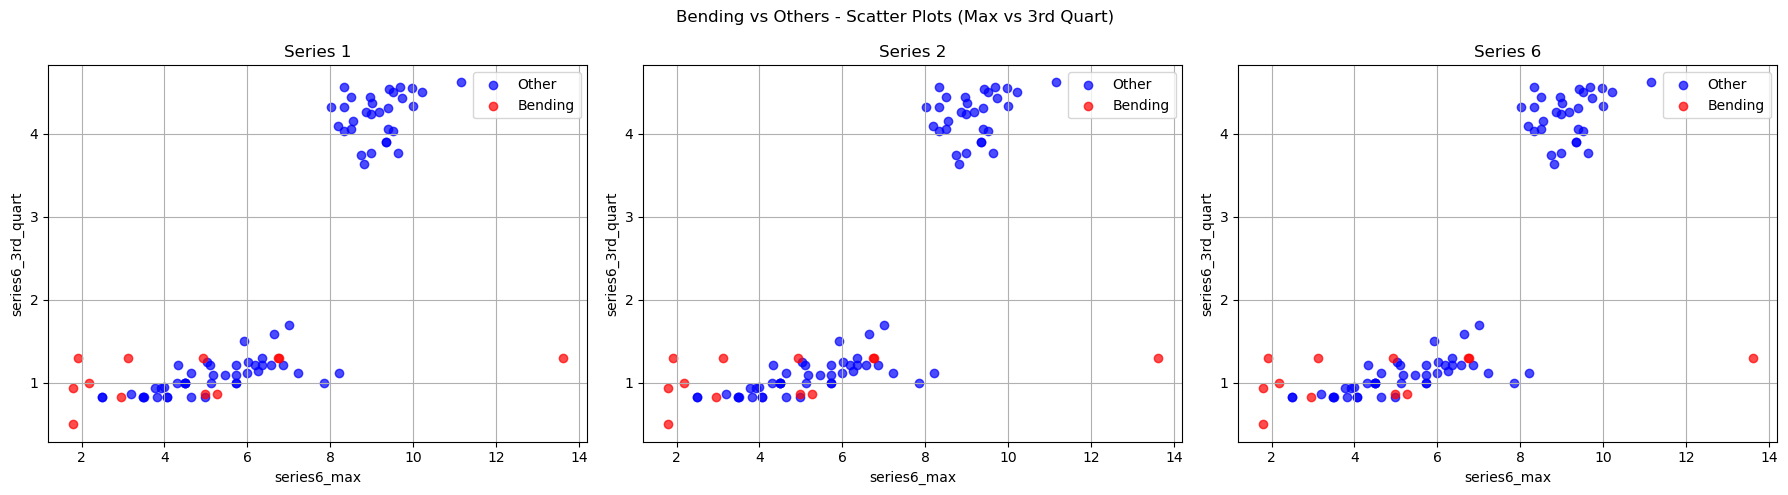

In [53]:
selected_series = [1, 2, 6]
selected_stats = ['max', '3rd_quart', '1st_quart']

selected_columns = [f"series{s}_{stat}" for s in selected_series for stat in selected_stats]

# Extract the training data
X = full_df.loc[:87, selected_columns].values
y_raw = labels[:88]

# Build binary classification labels.
y = np.array([1 if 'bending' in label else 0 for label in y_raw])

# Output the results.
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
series_labels = {1: "Series 1", 2: "Series 2", 6: "Series 6"}

for idx, series_id in enumerate(selected_series):
    x_feat = f"series{sensor_id}_max"
    y_feat = f"series{sensor_id}_3rd_quart"
    x = full_df.loc[:87, x_feat].values
    y_val = full_df.loc[:87, y_feat].values

    for cls, color, label_name in zip([0, 1], ['blue', 'red'], ['Other', 'Bending']):
        mask = np.array([1 if 'bending' in label else 0 for label in y_raw]) == cls
        axes[idx].scatter(
            x[mask],
            y_val[mask],
            label=label_name,
            color=color,
            alpha=0.7
        )
    
    axes[idx].set_xlabel(f"{x_feat}")
    axes[idx].set_ylabel(f"{y_feat}")
    axes[idx].set_title(f"{series_labels[series_id]}")
    axes[idx].legend()
    axes[idx].grid(True)

plt.suptitle("Bending vs Others - Scatter Plots (Max vs 3rd Quart)")
plt.tight_layout()
plt.show()